Wenhao Li, 1004005854

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import cplex
import cyipopt as ipopt
import math
import matplotlib.pyplot as plt

# Implement investment strategies

## “Buy and hold” strategy

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

## “Equally weighted” (also known as “1/n”) portfolio strategy

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    # Equal weight
    w = np.ones(n) / n
    # Portfolio total value
    portfolio_total_value = cash_init + np.dot(x_init, cur_prices)
    # round the number of shares bought or sold to integer values
    x_optimal = np.floor(w * portfolio_total_value / cur_prices)
    # Transaction cost
    transaction_cost = 0.005 * np.dot(cur_prices, abs(x_init - x_optimal))
    # Need to subtract transaction fees
    cash_optimal =  portfolio_total_value - transaction_cost - np.dot(x_optimal, cur_prices)
    return x_optimal, cash_optimal

## “Minimum variance” portfolio strategy

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
   
    # Initialize CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
   
    # Define linear part of objective function and bounds on variables
    n = 20
    c = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,0]])
    var_names = ["w_%s" % i for i in range(1,n+1)]

    # Add constraints, objective function
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    # Add quadratic part of objective function to CPLEX model
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
   
    # Set CPLEX parameters
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.threads.set(alg.concurrent)
   
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)

    # Optimize the problem
    cpx.solve()

    # Optimal weight, Compute the result
    w_minVar = cpx.solution.get_values()
    # Portfolio total value
    portfolio_total_value = cash_init + np.dot(x_init, cur_prices)
    # round the number of shares bought or sold to integer values
    x_optimal = np.floor(w_minVar * (portfolio_total_value / cur_prices))
    # Transaction cost
    transaction_cost = 0.005 * np.dot(cur_prices, abs(x_init - x_optimal))
    # Need to subtract transaction fees
    cash_optimal =  portfolio_total_value - transaction_cost - np.dot(x_optimal, cur_prices)
    return x_optimal, cash_optimal

## “Maximum Sharpe ratio” portfolio strategy

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    # Select risk-free rate based on year
    if cur_year == 2008:
        r_rf = 0.045
    elif cur_year == 2020:
        r_rf = 0.025
    else:
        r_rf = 0.0375
    
    # Daily risk free rate
    r_rf = 0.025
    r_rf_daily = (1+r_rf)**(1.0/252) - 1
    # Difference
    Difference_SR = mu - r_rf_daily

    # New row and column for risk free asset
    Q = np.append(Q, np.zeros((20,1)),axis=1)
    Q = np.vstack([Q,np.zeros((21))])

    # Initialize CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    # Define linear part of objective function and bounds on variables
    c = [0.0] * 21
    lb = [0.0] * 21
    ub = [np.inf] * 21
    A = []
    for k in range(20):
        A.append([[0,1],[Difference_SR[k],1.0]])
    A.append([[0,1],[0,-1.0]])
    var_names = ["y_%s" % i for i in range(1,22)]

    # Add constraints, objective function
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    # Add quadratic part of objective function to CPLEX model
    Qmat = [[list(range(21)), list(2*Q[k,:])] for k in range(21)]
    cpx.objective.set_quadratic(Qmat)
   
    # Set CPLEX parameters
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.threads.set(alg.concurrent)
   
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)

    # Optimize the problem
    cpx.solve()

    # Optimal weight, Compute the result
    w = np.array(cpx.solution.get_values())
    w_minVar = w[0:20]/w[20]
    # Portfolio total value
    portfolio_total_value = cash_init + np.dot(x_init, cur_prices)   
    # round the number of shares bought or sold to integer values
    x_optimal = np.floor(w_minVar * (portfolio_total_value / cur_prices))
    # Transaction cost
    transaction_cost = 0.005 * np.dot(cur_prices, abs(x_init - x_optimal))
    # Need to subtract transaction fees
    cash_optimal =  portfolio_total_value - transaction_cost - np.dot(x_optimal, cur_prices)

    return x_optimal, cash_optimal

## “Equal risk contributions” portfolio strategy

In [6]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    class erc(object):
        def __init__(self):
            pass
    
        def objective(self,x):
            # The callback for calculating the objective
            y = x * np.dot(Q,x)
            fval = 0
            for i in range(20):
                for j in range(i,20):
                    xij = y[i] - y[j]
                    fval = fval + xij * xij
            fval = 2*fval
            return fval
    
        def gradient(self,x):
            # The call back for calculating the gradient
            grad = np.zeros(20)
            # Finite difference to check the gradient
            y = x * np.dot(Q,x)
            for i in range(20):
                for j in range(i,20):
                    diff_1 = np.dot(Q[i], x)
                    diff_2 = Q[i,j] * x[i]
                    g_j = (y[i] - y[j]) * (diff_1 - diff_2)
                    grad[i] = grad[i] + g_j
                grad[i] = grad[i] * 2 * 2
            return grad
                
        def constraints(self,x):
            # The callback for calculating the constraints
            return [1.0] * 20
    
        def jacobian(self,x):
            # The callback for calculating the jacobian
            return np.array([[1.0] * 20])
    
    
    w0 = [1/20] * 20
    lb = [0.0] * 20
    ub = [1.0] * 20
    cl = [1]
    cu = [1]
    
    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('print_level'.encode('utf-8'),0)
    # Solve the problem
    w_erc, info = nlp.solve(w0)
   
    # Portfolio total value
    portfolio_total_value = cash_init + np.dot(x_init, cur_prices)
    # round the number of shares bought or sold to integer values
    x_optimal = np.floor(w_erc * (portfolio_total_value / cur_prices))
    # Transaction cost
    transaction_cost = 0.005 * np.dot(cur_prices, abs(x_init - x_optimal))
    # Need to subtract transaction fees
    cash_optimal =  portfolio_total_value - transaction_cost - np.dot(x_optimal, cur_prices)
    
    return x_optimal, cash_optimal

## “Leveraged equal risk contributions” portfolio strategy

In [7]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):

    class erc(object):
        def __init__(self):
            pass
    
        def objective(self,x):
            # The callback for calculating the objective
            y = x * np.dot(Q,x)
            fval = 0
            for i in range(20):
                for j in range(i,20):
                    xij = y[i] - y[j]
                    fval = fval + xij * xij
            fval = 2*fval
            return fval
    
        def gradient(self,x):
            # The call back for calculating the gradient
            grad = np.zeros(20)
            # Finite difference to check the gradient
            y = x * np.dot(Q,x)
            for i in range(20):
                for j in range(i,20):
                    diff_1 = np.dot(Q[i], x)
                    diff_2 = Q[i,j] * x[i]
                    g_j = (y[i] - y[j]) * (diff_1 - diff_2)
                    grad[i] = grad[i] + g_j
                grad[i] = grad[i] * 2 * 2
            return grad
                
        def constraints(self,x):
            # The callback for calculating the constraints
            return [1.0] * 20
    
        def jacobian(self,x):
            # The callback for calculating the jacobian
            return np.array([[1.0] * 20])

    # Select risk-free rate based on year
    if cur_year == 2008:
        r_rf = 0.045
    elif cur_year == 2020:
        r_rf = 0.025
    else:
        r_rf = 0.0375
    
    # Portfolio total value
    portfolio_total_value = cash_init + np.dot(x_init, cur_prices)
    # Short initial portfolio, Interest
    short_asset = portfolio_total_value
    interest = (r_rf/6) * short_asset

    if period == 1:
        portfolio_total_value = portfolio_total_value + short_asset
    
    w0 = [1/20] * 20
    lb = [0.0] * 20
    ub = [1.0] * 20
    cl = [1]
    cu = [1]
    
    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('print_level'.encode('utf-8'),0)
    # Solve the problem
    w_lerc, info = nlp.solve(w0)
    
    # round the number of shares bought or sold to integer values
    x_optimal = np.floor(w_lerc * (portfolio_total_value / cur_prices))
    # Transaction cost
    transaction_cost = 0.005 * np.dot(cur_prices, abs(x_init - x_optimal))
    # Need to subtract transaction fees
    cash_optimal =  portfolio_total_value - transaction_cost - np.dot(x_optimal, cur_prices) - interest
    
    return x_optimal, cash_optimal

## “Robust mean-variance optimization” portfolio strategy

In [8]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    
    w0 = [1.0/20] * 20
    
    # Required portfolio robustness
    var_matr = np.diag(np.diag(Q))
    # Target portfolio return estimation error is return estimation error of 1/n portfolio
    # Return estimation error of initial portfolio
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    # Target portfolio return estimation error
    rob_bnd  = rob_init 
    
    
    # Return constraint
    # Select risk-free rate based on year
    if cur_year == 2008:
        r_rf = 0.045
    elif cur_year == 2020:
        r_rf = 0.025
    else:
        r_rf = 0.0375
    
    r_rf_daily = (1 + r_rf) ** (1/252) - 1
    Portf_Retn = r_rf_daily # Use daily risk-free return

    # Initialize CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c = [0.0] * 20
    lb = [0.0] * 20
    ub = [1.0] * 20
    A = []
    for k in range(20):
        A.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,20+1)]
    
    
    
    # Add constraints, objective function
    cpx.linear_constraints.add(rhs=[1.0, Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    # Add quadratic part of objective function to CPLEX model
    Qmat = [[list(range(20)), list(2*Q[k,:])] for k in range(20)]
    cpx.objective.set_quadratic(Qmat)
   
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(20), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")

    # Set number of threads, timelimit, barrier algorithm convergence tolerance
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)

    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)

    # Optimize the problem
    cpx.solve()

    # Optimal weight, Compute the result
    w_ro = cpx.solution.get_values()
    
    # Portfolio total value
    portfolio_total_value = cash_init + np.dot(x_init, cur_prices)
    # round the number of shares bought or sold to integer values
    x_optimal = np.floor(w_ro * (portfolio_total_value / cur_prices))
    # Transaction cost
    transaction_cost = 0.005 * np.dot(cur_prices, abs(x_init - x_optimal))
    # Need to subtract transaction fees
    cash_optimal =  portfolio_total_value - transaction_cost - np.dot(x_optimal, cur_prices)
    
    return x_optimal, cash_optimal


In [9]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

# Empty set for period, start day, end day
period_list = []

for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 20:
        cur_year  = 20 + math.floor(period/7)
    else:
        cur_year  = 2020 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        
        
        
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        while cash[strategy, period-1] < 0:
            if strategy == 5 and period == 1:
                portfolio_total_value = 2 * (np.dot(curr_positions, cur_prices) + curr_cash)
            else:
                portfolio_total_value = np.dot(curr_positions, cur_prices) + curr_cash
            ratio =  x[strategy,period-1]/ np.sum(x[strategy,period-1])
            cash_negative = ratio * abs(cash[strategy,period-1])
            x_negative = np.ceil(cash_negative / cur_prices)
            x[strategy,period-1] = x[strategy,period-1] - x_negative  # Adjust
            # New
            transaction_cost_adjust = 0.005 * np.dot(cur_prices, abs(x[strategy,period-1] - curr_positions))
            cash[strategy,period-1] = portfolio_total_value - np.dot(cur_prices, x[strategy,period-1]) - transaction_cost_adjust
        
        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        period_list.append(day_ind_end)
        
        if strategy == 5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
        else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)




Initial portfolio value = $ 1000013.0


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000013.00, value end = $ 893956.82
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.24, value end = $ 893208.59
  Strategy "Minimum Variance Portfolio", value begin = $ 992758.41, value end = $ 916240.12
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.08, value end = $ 922087.12

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991288.01, value end = $ 899923.39
  Strategy "Leveraged Equal Risk Contributions Portfolio", v

  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1885257.93, value end = $ 1919893.29
  Strategy "Robust Optimization Portfolio", value begin = $ 1353676.13, value end = $ 1324125.60

Period 12: start date 11/01/2021, end date 12/31/2021
  Strategy "Buy and Hold", value begin = $ 951350.41, value end = $ 932471.35
  Strategy "Equally Weighted Portfolio", value begin = $ 1584847.25, value end = $ 1646671.96
  Strategy "Minimum Variance Portfolio", value begin = $ 1054688.50, value end = $ 1048743.13
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 2113773.28, value end = $ 2217106.01
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1472091.78, value end = $ 1525660.82
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1942049.10, value end = $ 2048505.11
  Strategy "Robust Optimization Portfolio", value begin = $ 1317873.22, value end = $ 1347162.78


# Plot the results

## Plot that the daily value of the portfolio (for each of the seven trading strategies) over the years 2020 and 2021 using daily prices provided.

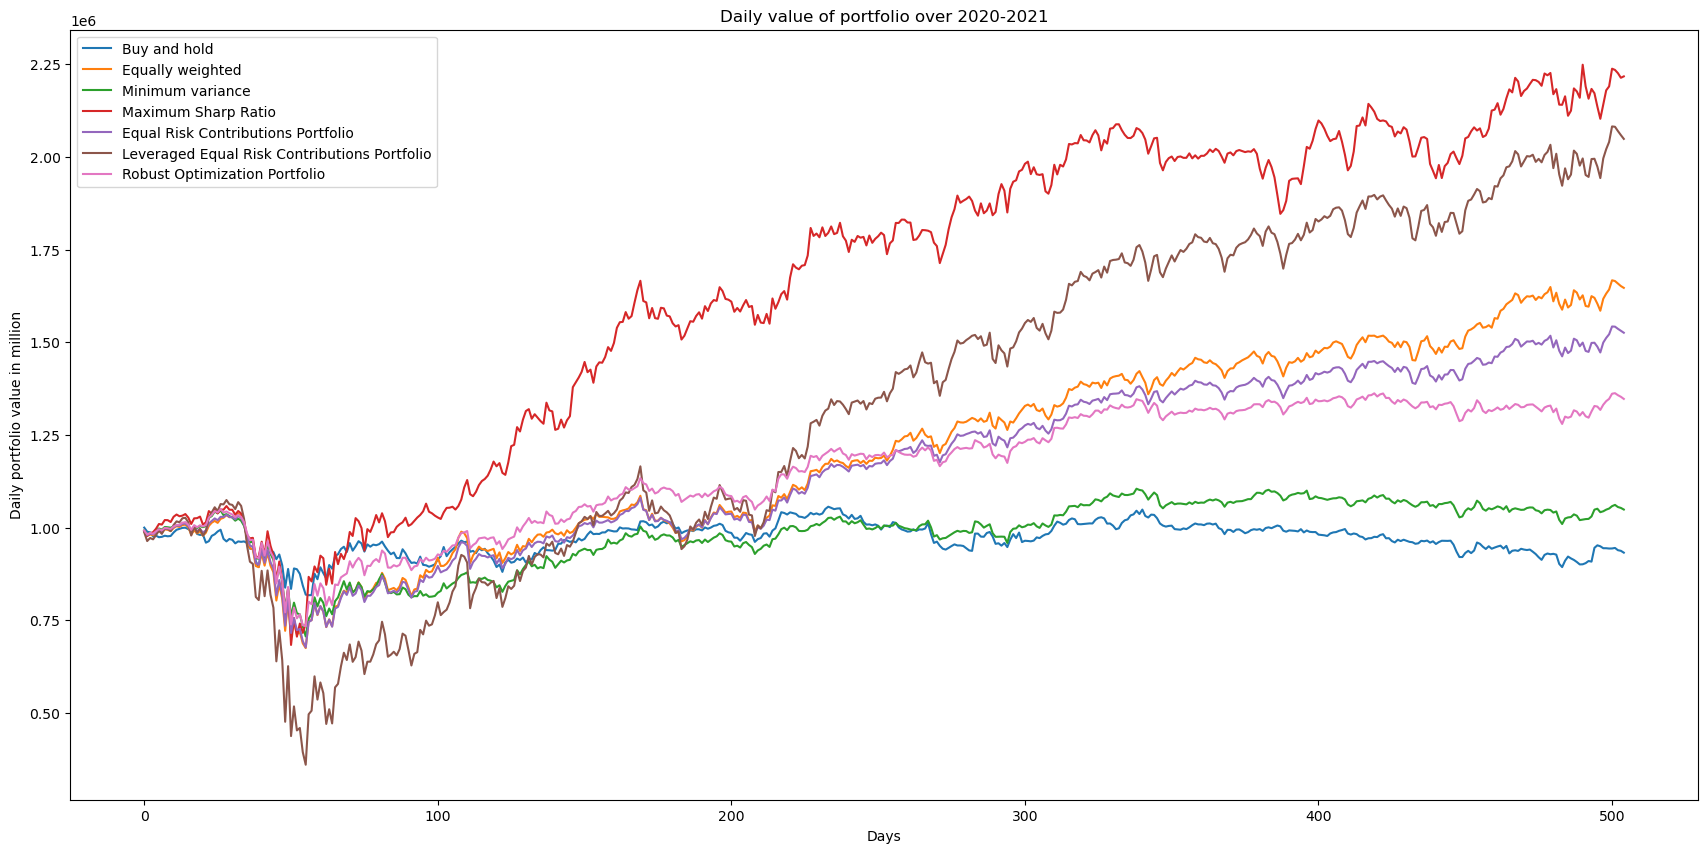

In [10]:
# Plot the daily value of the portfolio (for each trading strategy) over the years 2020 and 2021
plt.figure(figsize=(21,10))
plt.plot(portf_value[0], label = 'Buy and hold')
plt.plot(portf_value[1], label = 'Equally weighted')
plt.plot(portf_value[2], label = 'Minimum variance')
plt.plot(portf_value[3], label = 'Maximum Sharp Ratio')
plt.plot(portf_value[4], label = 'Equal Risk Contributions Portfolio')
plt.plot(portf_value[5], label = 'Leveraged Equal Risk Contributions Portfolio')
plt.plot(portf_value[6], label = 'Robust Optimization Portfolio')
plt.xlabel('Days')
plt.ylabel('Daily portfolio value in million')
plt.title('Daily value of portfolio over 2020-2021')
plt.legend()
plt.show()

## Plot that illustrates maximum drawdown of your portfolio (for each of the seven trading strategies) for each of the 12 periods (years 2020 and 2021)

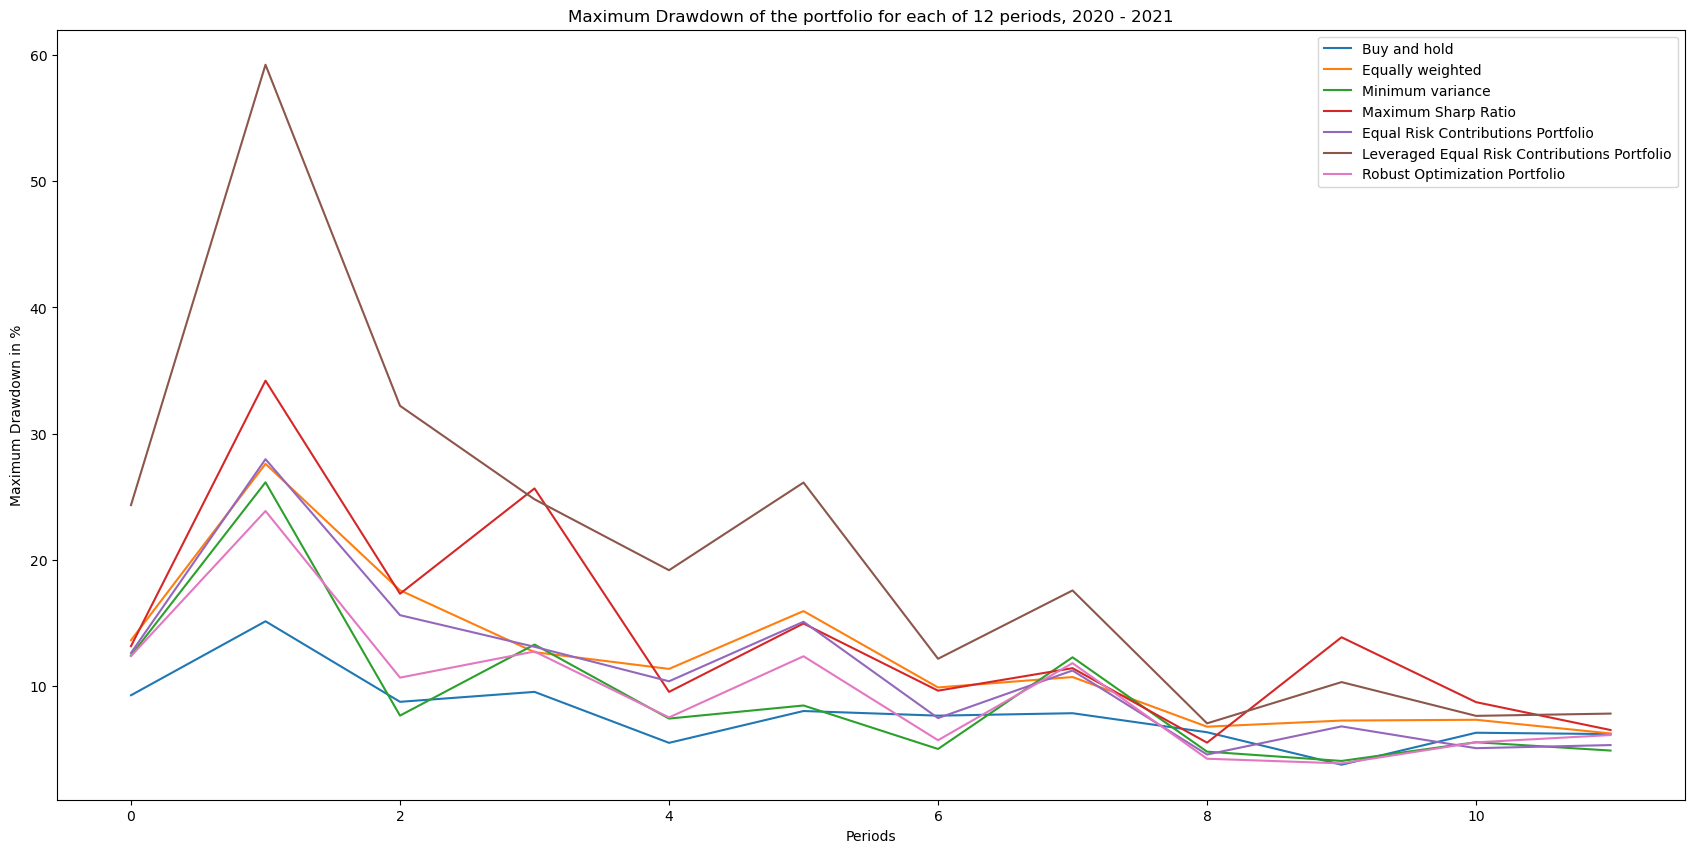

In [11]:
# Empty set for Maximum Drawdown value for each period and each strategy
max_drawdown = [[0] * 12 for k in range(7)]

# Period list, include end day for each period
period_list_unique = np.unique(period_list)
period_list_unique = np.append(0,period_list_unique)

for i in range(7):
    for j in range(12):
        drawdown = 100 * (portf_value[i][period_list_unique[j]:period_list_unique[j+1]].max() - portf_value[i][period_list_unique[j]:period_list_unique[j+1]].min()) / portf_value[i][period_list_unique[j]:period_list_unique[j+1]].max()
        max_drawdown[i][j] = drawdown

plt.figure(figsize=(21,10))
plt.plot(max_drawdown[0], label = 'Buy and hold')
plt.plot(max_drawdown[1], label = 'Equally weighted')
plt.plot(max_drawdown[2], label = 'Minimum variance')
plt.plot(max_drawdown[3], label = 'Maximum Sharp Ratio')
plt.plot(max_drawdown[4], label = 'Equal Risk Contributions Portfolio')
plt.plot(max_drawdown[5], label = 'Leveraged Equal Risk Contributions Portfolio')
plt.plot(max_drawdown[6], label = 'Robust Optimization Portfolio')
plt.xlabel('Periods')
plt.ylabel('Maximum Drawdown in %')
plt.title('Maximum Drawdown of the portfolio for each of 12 periods, 2020 - 2021')
plt.legend()
plt.show()   

## Plot to show dynamic changes in portfolio allocations under strategy 7.

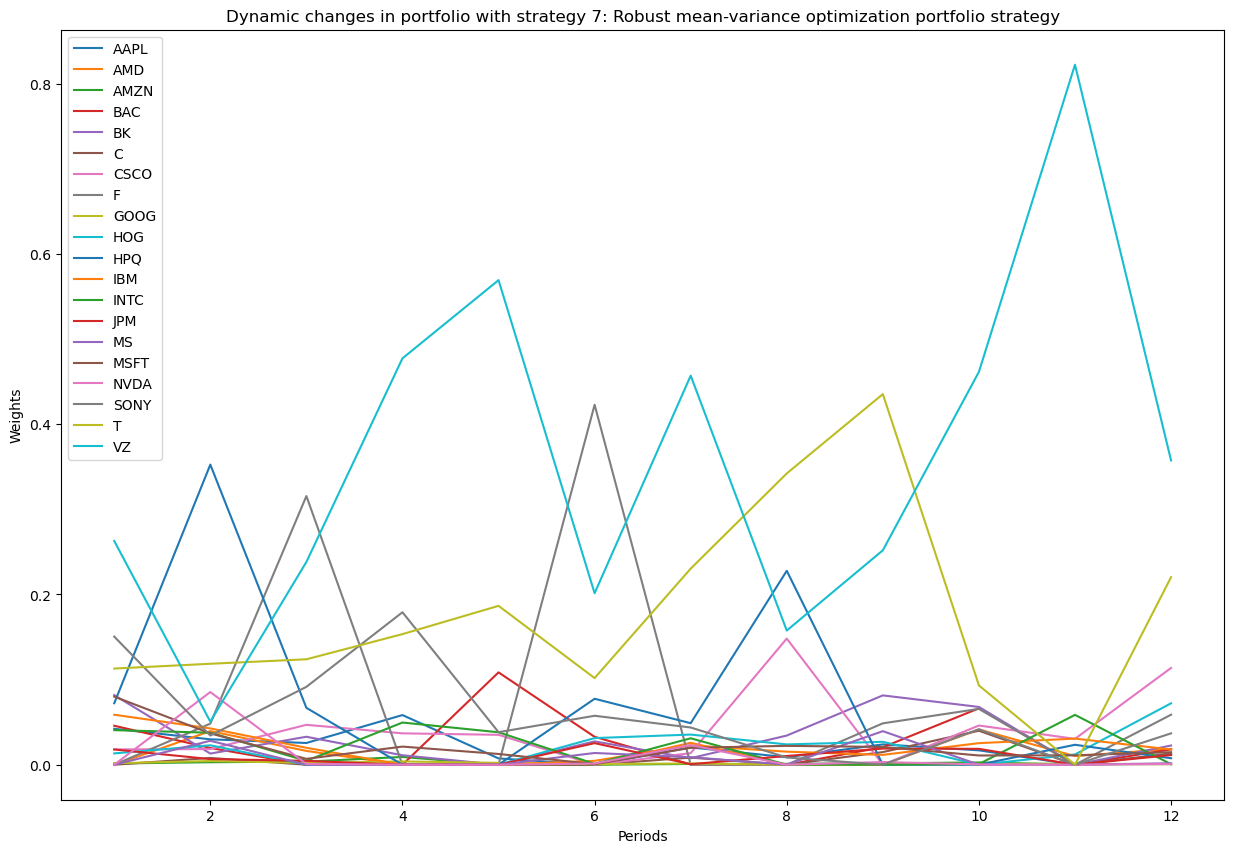

In [12]:
list_stock = df.columns[1:]

w_7 = []
for i in range(12):
    w_7.append(x[6,i] / sum(x[6,i]))

plt.figure(figsize=(15,10))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12],w_7, label = list_stock)
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.title('Dynamic changes in portfolio with strategy 7: Robust mean-variance optimization portfolio strategy')
plt.legend()
plt.show()

# Test trading strategies for years 2008 and 2009:

## Import data and make some function change

Need to make some change in fucntion strat_max_Sharpe & strat_robust_optim to make sure no infeasible solution

In [13]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    # Portfolio total value
    portfolio_total_value = cash_init + np.dot(x_init, cur_prices)   
    
    # Select risk-free rate based on year
    if cur_year == 2008:
        r_rf = 0.045
    elif cur_year == 2020:
        r_rf = 0.025
    else:
        r_rf = 0.0375
    
    # Daily risk free rate
    r_rf = 0.025
    r_rf_daily = (1+r_rf)**(1.0/252) - 1
    # Difference
    Difference_SR = mu - r_rf_daily

    # New row and column for risk free asset
    Q = np.append(Q, np.zeros((20,1)),axis=1)
    Q = np.vstack([Q,np.zeros((21))])

    # Initialize CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    # Define linear part of objective function and bounds on variables
    c = [0.0] * 21
    lb = [0.0] * 21
    ub = [np.inf] * 21
    A = []
    for k in range(20):
        A.append([[0,1],[Difference_SR[k],1.0]])
    A.append([[0,1],[0,-1.0]])
    var_names = ["y_%s" % i for i in range(1,22)]

    # Add constraints, objective function
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    # Add quadratic part of objective function to CPLEX model
    Qmat = [[list(range(21)), list(2*Q[k,:])] for k in range(21)]
    cpx.objective.set_quadratic(Qmat)
   
    # Set CPLEX parameters
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.threads.set(alg.concurrent)
   
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)

    # Optimize the problem
    cpx.solve()
    
    
    
    # The original function results in 'CPLEX Error  1217: No solution exists'. Need to prevent infeasible soultion
    if cpx.solution.get_status() == cpx.solution.status.infeasible:
        x_optimal = x_init
        cash_optimal =  cash_init
    else:
        # Optimal weight, Compute the result
        w = np.array(cpx.solution.get_values())
        w_minVar = w[0:20]/w[20]
        # round the number of shares bought or sold to integer values
        x_optimal = np.floor(w_minVar * (portfolio_total_value / cur_prices))
        # Transaction cost
        transaction_cost = 0.005 * np.dot(cur_prices, abs(x_init - x_optimal))
        # Need to subtract transaction fees
        cash_optimal =  portfolio_total_value - transaction_cost - np.dot(x_optimal, cur_prices)

    return x_optimal, cash_optimal

In [14]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    
    # Portfolio total value
    portfolio_total_value = cash_init + np.dot(x_init, cur_prices)
    
    w0 = [1.0/20] * 20
    
    # Required portfolio robustness
    var_matr = np.diag(np.diag(Q))
    # Return estimation error of initial portfolio
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    # Target portfolio return estimation error
    rob_bnd  = rob_init 
    
    
    # Return constraint
    # Select risk-free rate based on year
    if cur_year == 2008:
        r_rf = 0.045
    elif cur_year == 2020:
        r_rf = 0.025
    else:
        r_rf = 0.0375
    
    r_rf_daily = (1 + r_rf) ** (1/252) - 1
    Portf_Retn = r_rf_daily # Use daily risk-free return

    # Initialize CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c = [0.0] * 20
    lb = [0.0] * 20
    ub = [1.0] * 20
    A = []
    for k in range(20):
        A.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,20+1)]
    

    # Add constraints, objective function
    cpx.linear_constraints.add(rhs=[1.0, Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    # Add quadratic part of objective function to CPLEX model
    Qmat = [[list(range(20)), list(2*Q[k,:])] for k in range(20)]
    cpx.objective.set_quadratic(Qmat)
   
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(20), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")

    # Set number of threads, timelimit, barrier algorithm convergence tolerance
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)

    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)

    # Optimize the problem
    cpx.solve()

    # The original function results in 'CPLEX Error  1217: No solution exists'. Need to prevent infeasible soultion
    if cpx.solution.get_status() == cpx.solution.status.infeasible:
        x_optimal = x_init
        cash_optimal =  cash_init
    else:
        # Optimal weight, Compute the result
        w_ro = cpx.solution.get_values()
        # round the number of shares bought or sold to integer values
        x_optimal = np.floor(w_ro * (portfolio_total_value / cur_prices))
        # Transaction cost
        transaction_cost = 0.005 * np.dot(cur_prices, abs(x_init - x_optimal))
        # Need to subtract transaction fees
        cash_optimal =  portfolio_total_value - transaction_cost - np.dot(x_optimal, cur_prices)
    
    return x_optimal, cash_optimal


In [15]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

# Empty set for period, start day, end day
period_list = []

for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        
        
        
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        while cash[strategy, period-1] < 0:
            if strategy == 5 and period == 1:
                portfolio_total_value = 2 * (np.dot(curr_positions, cur_prices) + curr_cash)
            else:
                portfolio_total_value = np.dot(curr_positions, cur_prices) + curr_cash
            ratio =  x[strategy,period-1]/ np.sum(x[strategy,period-1])
            cash_negative = ratio * abs(cash[strategy,period-1])
            x_negative = np.ceil(cash_negative / cur_prices)
            x[strategy,period-1] = x[strategy,period-1] - x_negative  # Adjust
            # New
            transaction_cost_adjust = 0.005 * np.dot(cur_prices, abs(x[strategy,period-1] - curr_positions))
            cash[strategy,period-1] = portfolio_total_value - np.dot(cur_prices, x[strategy,period-1]) - transaction_cost_adjust
        
        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        period_list.append(day_ind_end)
        
        if strategy == 5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
        else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)




Initial portfolio value = $ 385097.15


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
  Strategy "Equally Weighted Portfolio", value begin = $ 381649.89, value end = $ 326929.57
  Strategy "Minimum Variance Portfolio", value begin = $ 383262.49, value end = $ 327144.09
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 381265.54, value end = $ 332652.59
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 381843.50, value end = $ 329236.52
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 380219.73, value end = $ 274959.17
  Strategy "Robust Optimization Portfolio", value begin = $ 382122.34, value end = $ 324820.84

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 325807.08, value end = $ 349997.20
  Strategy "Equally Weighted Portfolio", value begin = $ 322097.69, value end = $ 354821.22
  Strategy "Minimum

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 186606.59, value end = $ 211109.89
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 331014.99, value end = $ 369958.54
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 278064.74, value end = $ 355164.71
  Strategy "Robust Optimization Portfolio", value begin = $ 315273.41, value end = $ 352481.52


## Plot that the daily value of the portfolio (for each of the seven trading strategies) over the years 2008 and 2009 using daily prices provided.

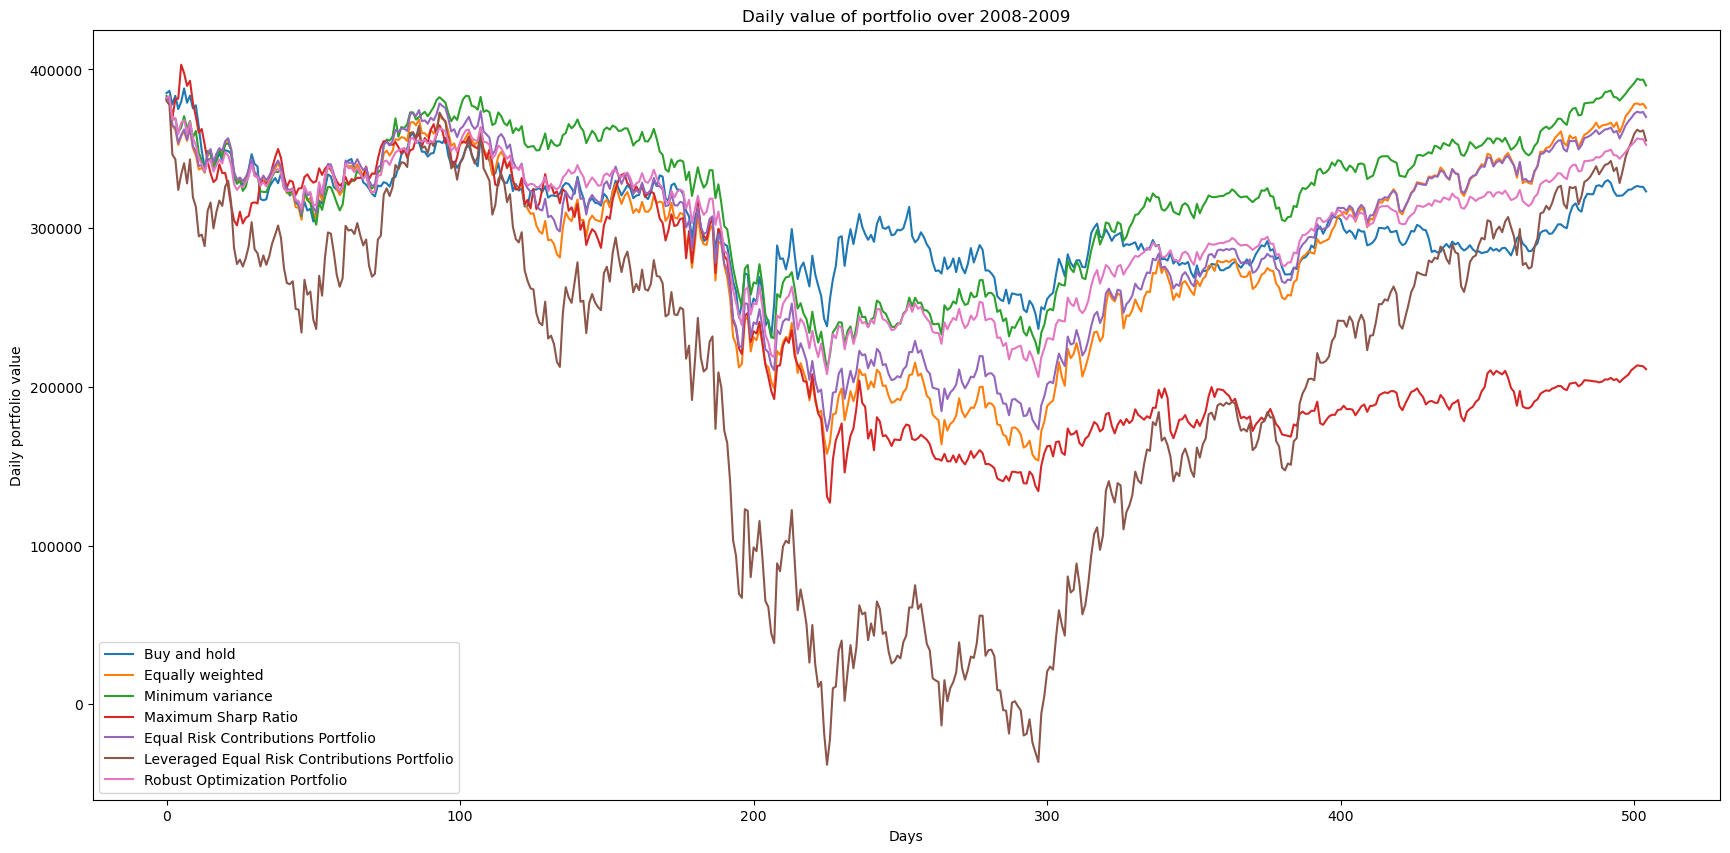

In [16]:
# Plot the daily value of the portfolio (for each trading strategy) over the years 2008 and 2009
plt.figure(figsize=(21,10))
plt.plot(portf_value[0], label = 'Buy and hold')
plt.plot(portf_value[1], label = 'Equally weighted')
plt.plot(portf_value[2], label = 'Minimum variance')
plt.plot(portf_value[3], label = 'Maximum Sharp Ratio')
plt.plot(portf_value[4], label = 'Equal Risk Contributions Portfolio')
plt.plot(portf_value[5], label = 'Leveraged Equal Risk Contributions Portfolio')
plt.plot(portf_value[6], label = 'Robust Optimization Portfolio')
plt.xlabel('Days')
plt.ylabel('Daily portfolio value')
plt.title('Daily value of portfolio over 2008-2009')
plt.legend()
plt.show()

## Plot that illustrates maximum drawdown of your portfolio (for each of the seven trading strategies) for each of the 12 periods (years 2008 and 2009)

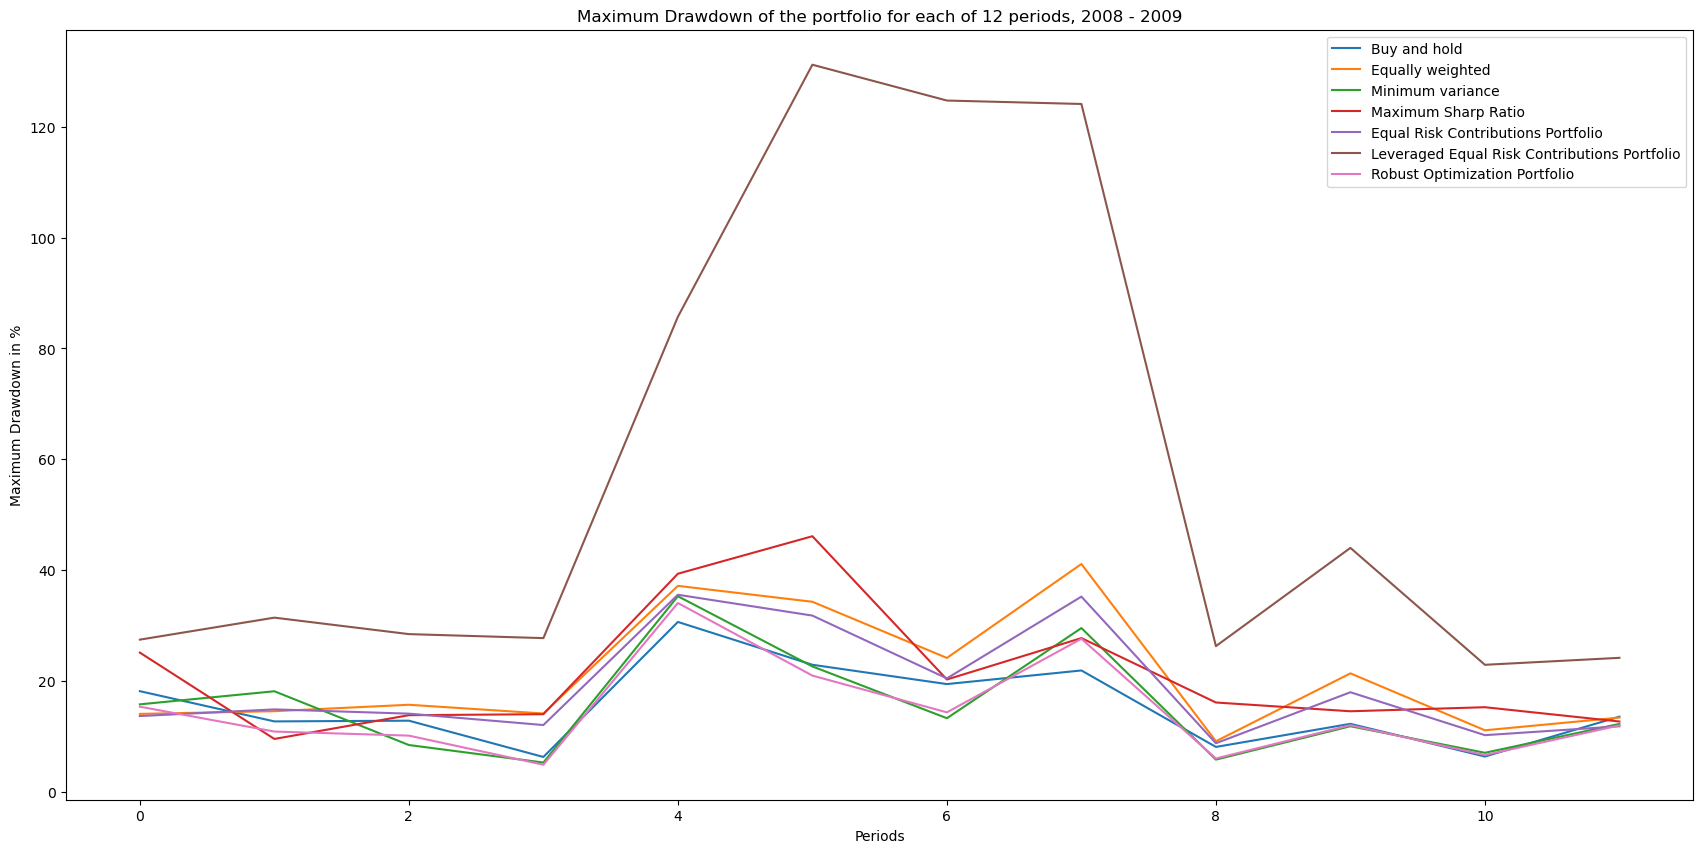

In [17]:
# Empty set for Maximum Drawdown value for each period and each strategy
max_drawdown = [[0] * 12 for k in range(7)]

# Period list, include end day for each period
period_list_unique = np.unique(period_list)
period_list_unique = np.append(0,period_list_unique)


for i in range(7):
    for j in range(12):
        drawdown = 100 * (portf_value[i][period_list_unique[j]:period_list_unique[j+1]].max() - portf_value[i][period_list_unique[j]:period_list_unique[j+1]].min()) / portf_value[i][period_list_unique[j]:period_list_unique[j+1]].max()
        max_drawdown[i][j] = drawdown
    
        
plt.figure(figsize=(21,10))
plt.plot(max_drawdown[0], label = 'Buy and hold')
plt.plot(max_drawdown[1], label = 'Equally weighted')
plt.plot(max_drawdown[2], label = 'Minimum variance')
plt.plot(max_drawdown[3], label = 'Maximum Sharp Ratio')
plt.plot(max_drawdown[4], label = 'Equal Risk Contributions Portfolio')
plt.plot(max_drawdown[5], label = 'Leveraged Equal Risk Contributions Portfolio')
plt.plot(max_drawdown[6], label = 'Robust Optimization Portfolio')
plt.xlabel('Periods')
plt.ylabel('Maximum Drawdown in %')
plt.title('Maximum Drawdown of the portfolio for each of 12 periods, 2008 - 2009')
plt.legend()
plt.show()   

## Plot to show dynamic changes in portfolio allocations under strategy 3, 4 & 7.

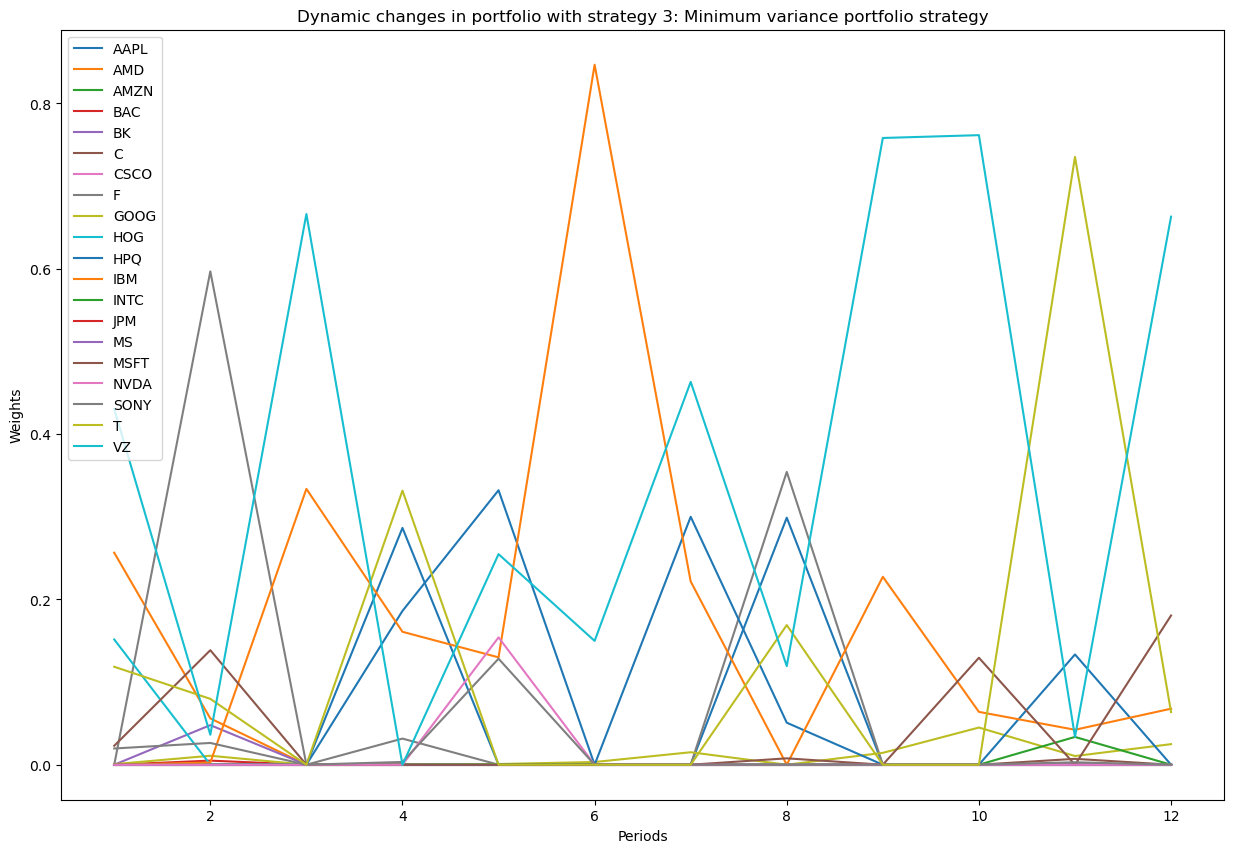

In [18]:
list_stock = df.columns[1:]

w_3 = []
for i in range(12):
    w_3.append(x[2,i] / sum(x[2,i]))

plt.figure(figsize=(15,10))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12],w_3, label = list_stock)
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.title('Dynamic changes in portfolio with strategy 3: Minimum variance portfolio strategy')
plt.legend()
plt.show()

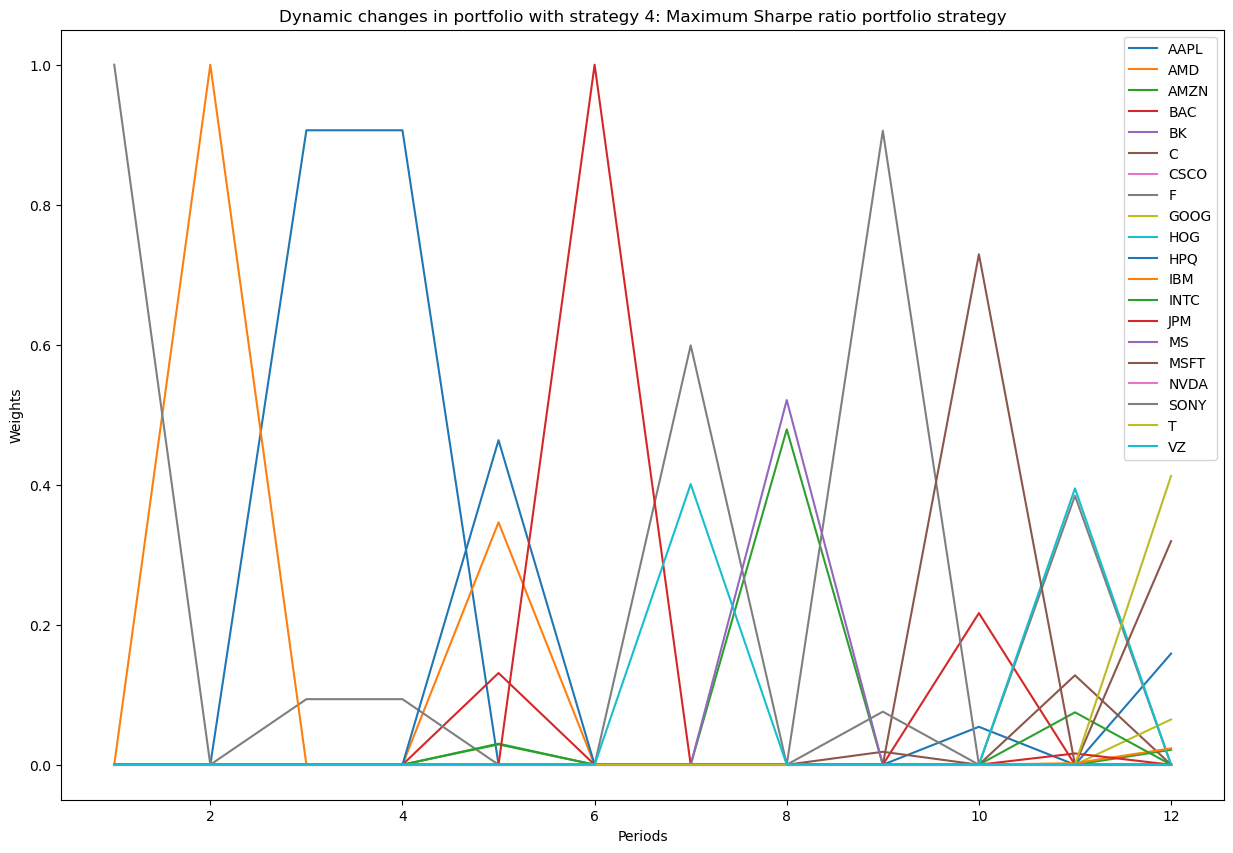

In [19]:
w_4 = []
for i in range(12):
    w_4.append(x[3,i] / sum(x[3,i]))

plt.figure(figsize=(15,10))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12],w_4, label = list_stock)
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.title('Dynamic changes in portfolio with strategy 4: Maximum Sharpe ratio portfolio strategy')
plt.legend()
plt.show()

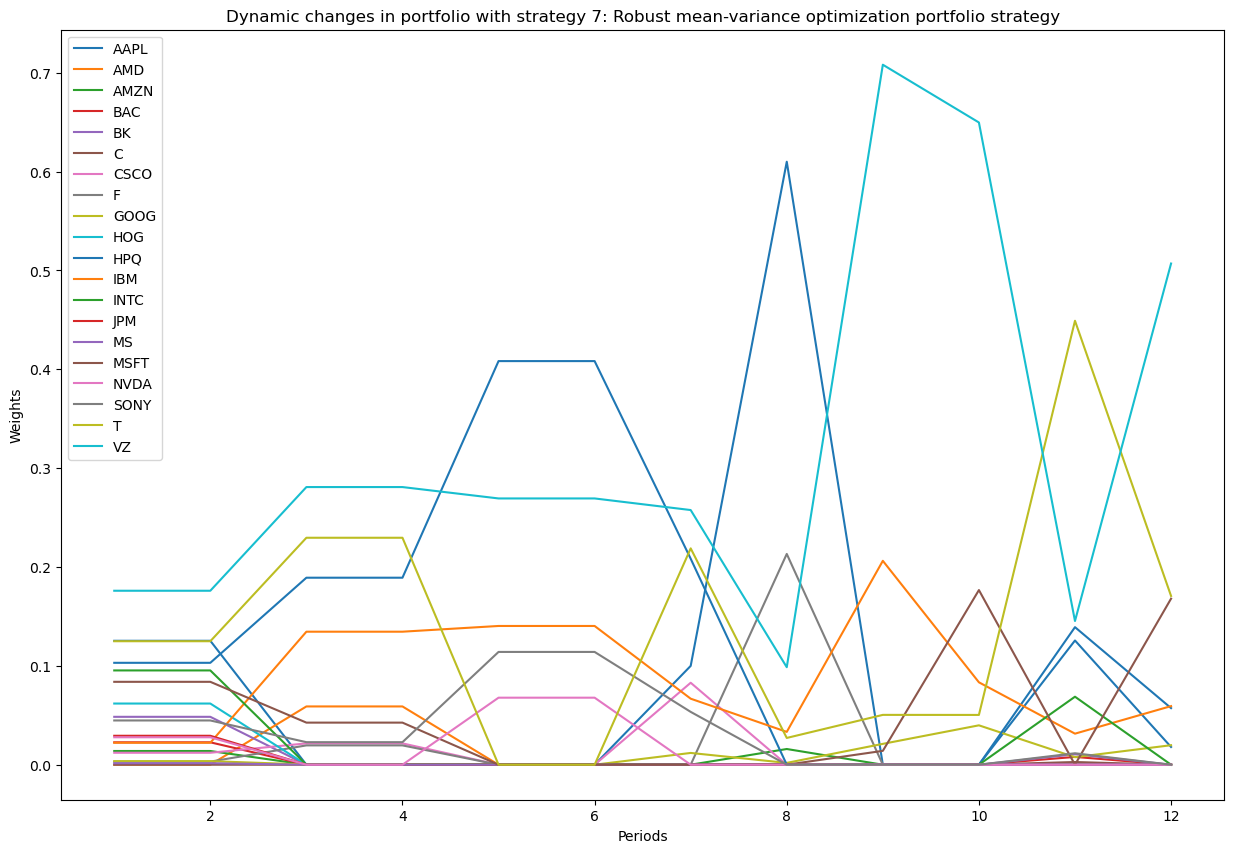

In [20]:
w_7 = []
for i in range(12):
    w_7.append(x[6,i] / sum(x[6,i]))

plt.figure(figsize=(15,10))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12],w_7, label = list_stock)
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.title('Dynamic changes in portfolio with strategy 7: Robust mean-variance optimization portfolio strategy')
plt.legend()
plt.show()

# Test trading strategies for years 2022:

## Import data and make some function change

In [21]:
# Input file
input_file_prices = 'Daily_closing_prices2022.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2021 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2021
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

# Empty set for period, start day, end day
period_list = []

for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 22:
        cur_year  = 22 + math.floor(period/7)
    else:
        cur_year  = 2022 + math.floor(period/7)
        
        

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        
        
        
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        while cash[strategy, period-1] < 0:
            if strategy == 5 and period == 1:
                portfolio_total_value = 2 * (np.dot(curr_positions, cur_prices) + curr_cash)
            else:
                portfolio_total_value = np.dot(curr_positions, cur_prices) + curr_cash
            ratio =  x[strategy,period-1]/ np.sum(x[strategy,period-1])
            cash_negative = ratio * abs(cash[strategy,period-1])
            x_negative = np.ceil(cash_negative / cur_prices)
            x[strategy,period-1] = x[strategy,period-1] - x_negative  # Adjust
            # New
            transaction_cost_adjust = 0.005 * np.dot(cur_prices, abs(x[strategy,period-1] - curr_positions))
            cash[strategy,period-1] = portfolio_total_value - np.dot(cur_prices, x[strategy,period-1]) - transaction_cost_adjust
        
        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        period_list.append(day_ind_end)
        
        if strategy == 5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
        else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)




Initial portfolio value = $ 890077.15


Period 1: start date 01/03/2022, end date 02/28/2022
  Strategy "Buy and Hold", value begin = $ 890077.15, value end = $ 924072.93
  Strategy "Equally Weighted Portfolio", value begin = $ 881997.57, value end = $ 802549.65
  Strategy "Minimum Variance Portfolio", value begin = $ 885873.66, value end = $ 863328.94
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 881222.37, value end = $ 800303.10
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 882721.03, value end = $ 818434.85
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 879476.36, value end = $ 750713.79
  Strategy "Robust Optimization Portfolio", value begin = $ 883675.91, value end = $ 828053.68

Period 2: start date 03/01/2022, end date 04/29/2022
  Strategy "Buy and Hold", value begin = $ 921940.14, value end = $ 807230.89
  Strategy "Equally Weighted Portfolio", value begin = $ 783067.12, value end = $ 705796.90
  Strategy "Minimum

## Plot that the daily value of the portfolio (for each of the seven trading strategies) over the year 2022 using daily prices provided.

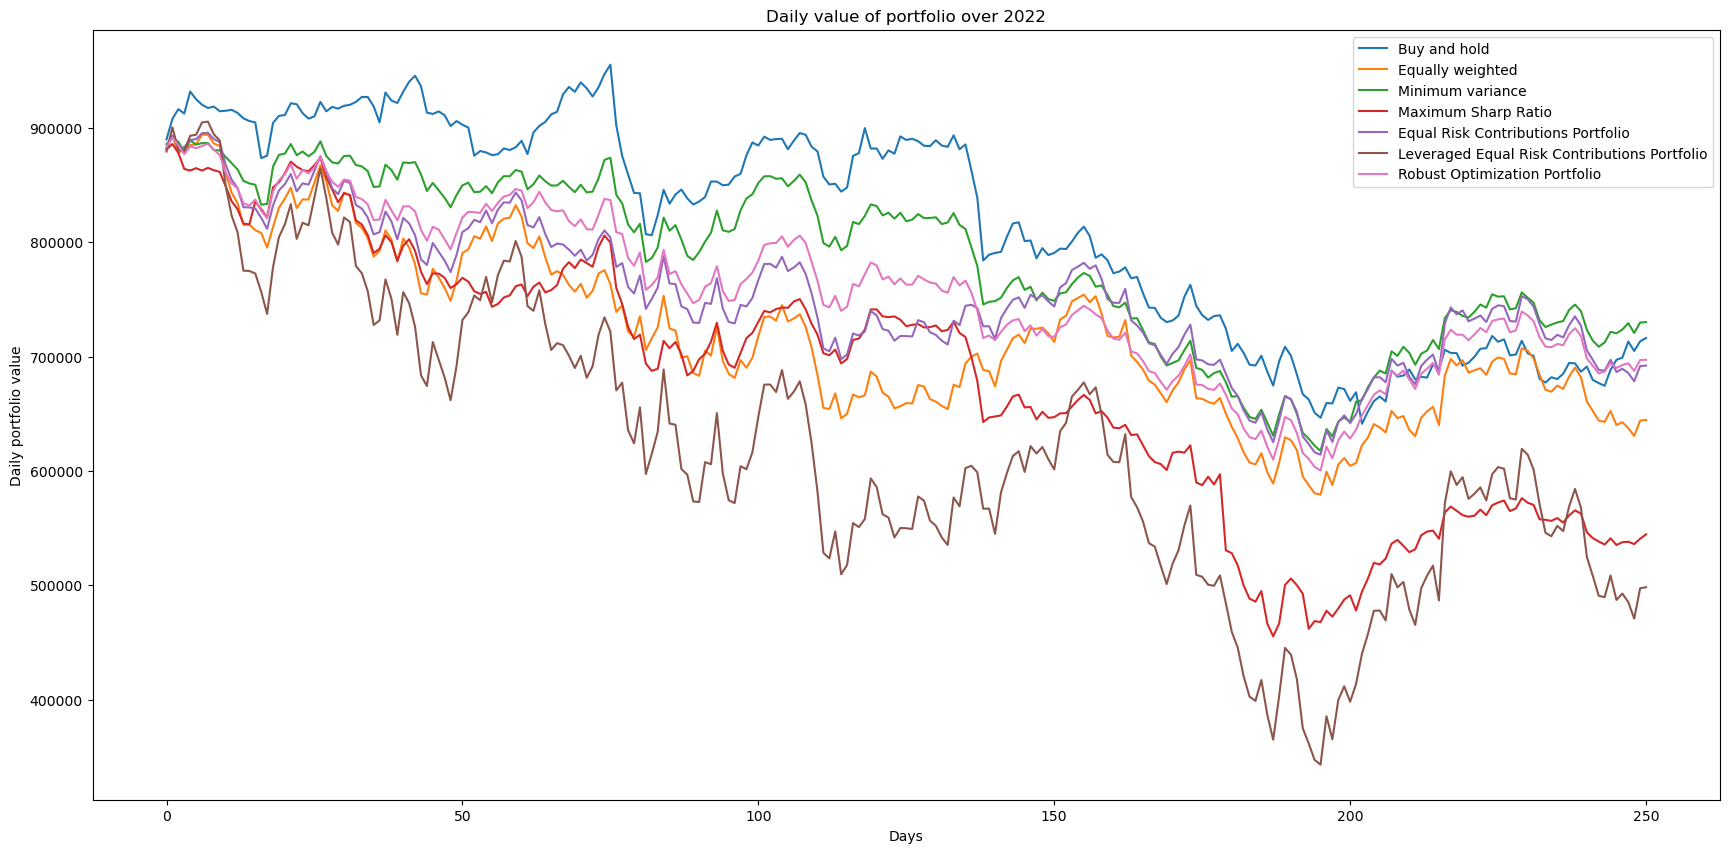

In [22]:
# Plot the daily value of the portfolio (for each trading strategy) over the years 2022
plt.figure(figsize=(21,10))
plt.plot(portf_value[0], label = 'Buy and hold')
plt.plot(portf_value[1], label = 'Equally weighted')
plt.plot(portf_value[2], label = 'Minimum variance')
plt.plot(portf_value[3], label = 'Maximum Sharp Ratio')
plt.plot(portf_value[4], label = 'Equal Risk Contributions Portfolio')
plt.plot(portf_value[5], label = 'Leveraged Equal Risk Contributions Portfolio')
plt.plot(portf_value[6], label = 'Robust Optimization Portfolio')
plt.xlabel('Days')
plt.ylabel('Daily portfolio value')
plt.title('Daily value of portfolio over 2022')
plt.legend()
plt.show()

## Plot that illustrates maximum drawdown of your portfolio (for each of the seven trading strategies) for each of the 6 periods (year 2022)

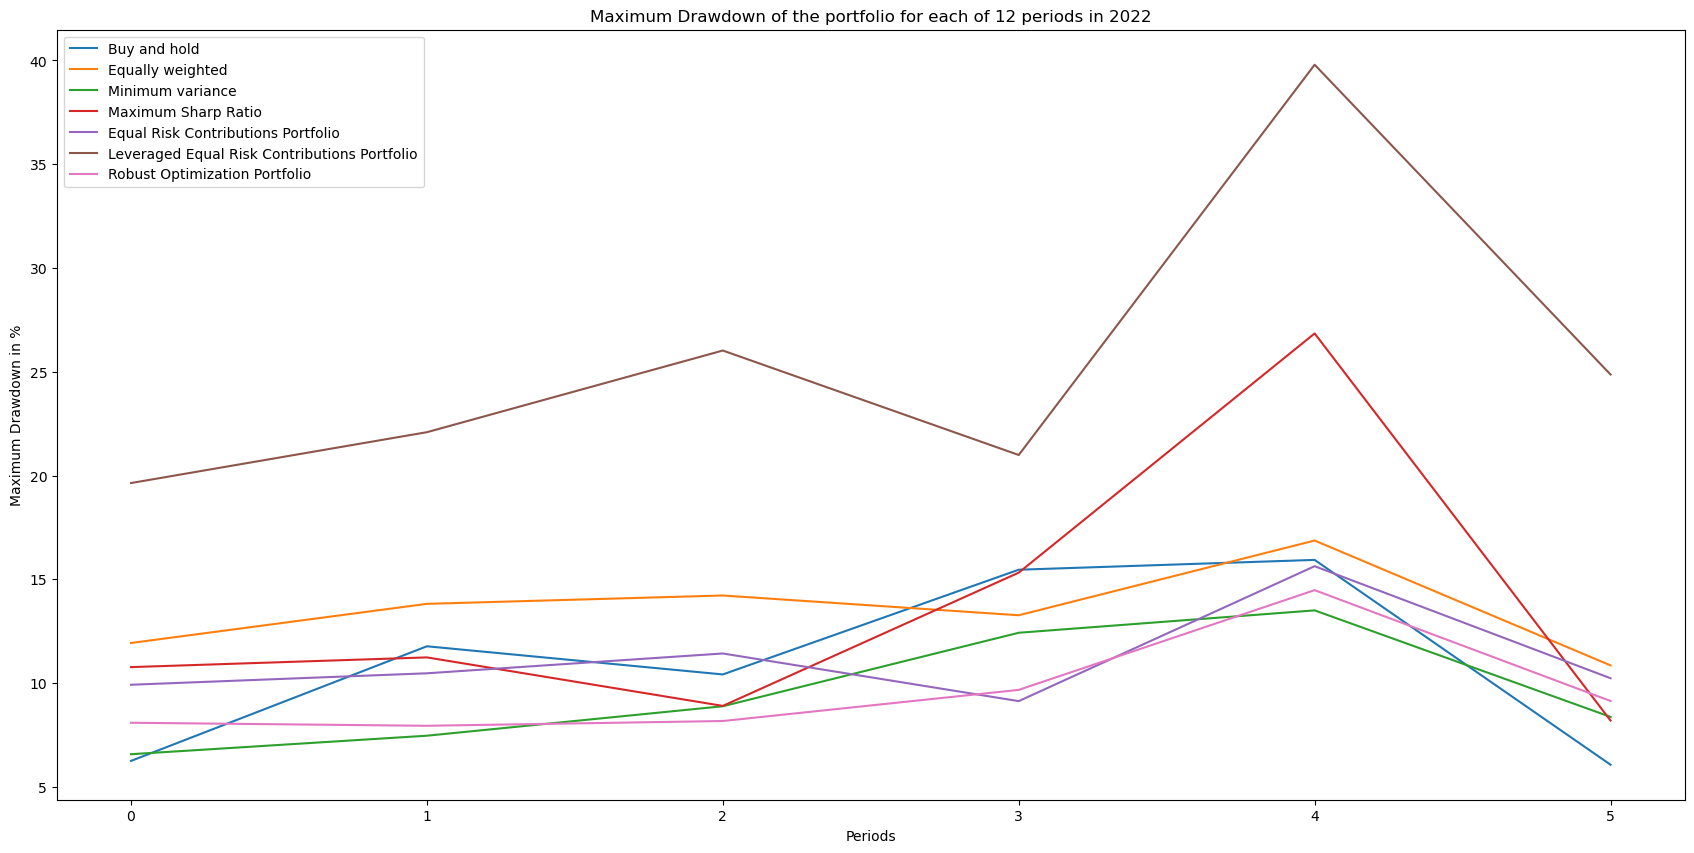

In [23]:
# Empty set for Maximum Drawdown value for each period and each strategy
max_drawdown = [[0] * 6 for k in range(7)]

# Period list, include end day for each period
period_list_unique = np.unique(period_list)
period_list_unique = np.append(0,period_list_unique)


for i in range(7):
    for j in range(6):
        drawdown = 100 * (portf_value[i][period_list_unique[j]:period_list_unique[j+1]].max() - portf_value[i][period_list_unique[j]:period_list_unique[j+1]].min()) / portf_value[i][period_list_unique[j]:period_list_unique[j+1]].max()
        max_drawdown[i][j] = drawdown
    
        
plt.figure(figsize=(21,10))
plt.plot(max_drawdown[0], label = 'Buy and hold')
plt.plot(max_drawdown[1], label = 'Equally weighted')
plt.plot(max_drawdown[2], label = 'Minimum variance')
plt.plot(max_drawdown[3], label = 'Maximum Sharp Ratio')
plt.plot(max_drawdown[4], label = 'Equal Risk Contributions Portfolio')
plt.plot(max_drawdown[5], label = 'Leveraged Equal Risk Contributions Portfolio')
plt.plot(max_drawdown[6], label = 'Robust Optimization Portfolio')
plt.xlabel('Periods')
plt.ylabel('Maximum Drawdown in %')
plt.title('Maximum Drawdown of the portfolio for each of 12 periods in 2022')
plt.legend()
plt.show()   